In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering & ML
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Bias Detection
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate
)

In [8]:
# dataset from kaggle - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset 

df = pd.read_csv("diabetes_dataset.csv", sep=",")
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'diabetes_dataset.csv'

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv('diabetes_dataset.csv')  # Update the path if needed

# Encode categorical variables
df_clean = df.copy()
label_encoders = {}
for col in ['gender', 'smoking_history']:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

# Separate features and target
X = df_clean.drop('diabetes', axis=1)
y = df_clean['diabetes']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


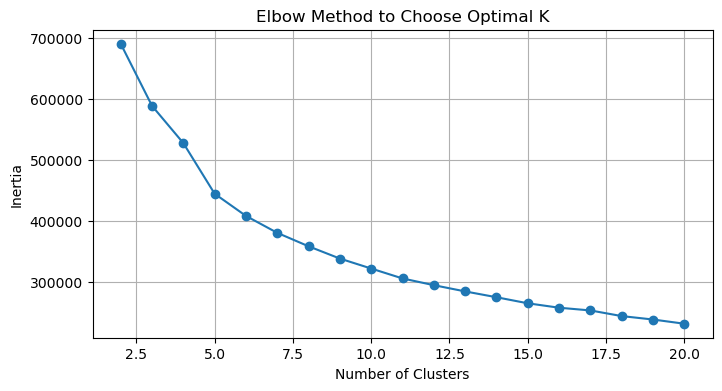

In [ ]:
#STEP 2 ----


import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"  # Limit OpenMP threads

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(2, 21)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method to Choose Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [ ]:
# Apply KMeans with 15 clusters
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled_df)

# Add the cluster labels back to the original data
X_scaled_df['cluster'] = cluster_labels
df_clean['cluster'] = cluster_labels

# See how many records are in each cluster
print(df_clean['cluster'].value_counts())


cluster
2     9283
10    9258
7     8912
11    8855
4     8403
13    8286
12    8258
1     7225
0     7094
3     7056
5     6304
9     4698
8     3026
14    2426
6      916
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Store results
results = []

# Loop through each cluster
for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    for gender_code, gender_label in zip([0, 1], ['Male', 'Female']):
        # Filter by gender
        gender_data = cluster_data[cluster_data['gender'] == gender_code]

        # Define features and target
        X = gender_data.drop(['diabetes', 'cluster'], axis=1)
        y = gender_data['diabetes']

        # Skip if too small OR only one class
        if len(gender_data) < 100 or len(y.unique()) < 2:
            continue

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train logistic regression
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_prob)

        # Save results
        results.append({
            'Cluster': cluster_id,
            'Gender': gender_label,
            'Samples': len(gender_data),
            'Accuracy': round(accuracy, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3),
            'F1 Score': round(f1, 3),
            'AUC': round(auc, 3)
        })

# Create results table
results_df = pd.DataFrame(results)
results_df


,Cluster,Gender,Samples,Accuracy,Precision,Recall,F1 Score,AUC
0,1,Male,7225,0.997,0.000,0.000,0.000,0.916
1,2,Female,9281,0.968,1.000,0.192,0.322,0.892
2,4,Male,8398,0.988,1.000,0.200,0.333,0.793
3,5,Male,3658,0.903,0.872,0.682,0.766,0.933
4,5,Female,2646,0.875,0.816,0.587,0.683,0.906
5,6,Male,393,0.835,0.806,0.781,0.794,0.908
6,6,Female,523,0.819,0.788,0.684,0.732,0.894
7,7,Female,8908,0.998,0.000,0.000,0.000,0.895
8,8,Male,1169,0.893,0.891,0.760,0.820,0.928
9,8,Female,1857,0.876,0.806,0.761,0.783,0.940


In [ ]:
# Pivot the results so each row is a cluster, and we have male/female side by side
pivoted = results_df.pivot(index='Cluster', columns='Gender', values=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Flatten column headers
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted.reset_index(inplace=True)

# Calculate gender bias: Female - Male for each metric
pivoted['Bias_Accuracy'] = pivoted['Accuracy_Female'] - pivoted['Accuracy_Male']
pivoted['Bias_Precision'] = pivoted['Precision_Female'] - pivoted['Precision_Male']
pivoted['Bias_Recall'] = pivoted['Recall_Female'] - pivoted['Recall_Male']
pivoted['Bias_F1'] = pivoted['F1 Score_Female'] - pivoted['F1 Score_Male']
pivoted['Bias_AUC'] = pivoted['AUC_Female'] - pivoted['AUC_Male']

# Display the bias table
pivoted[['Cluster', 'Bias_Accuracy', 'Bias_Precision', 'Bias_Recall', 'Bias_F1', 'Bias_AUC']]


,Cluster,Bias_Accuracy,Bias_Precision,Bias_Recall,Bias_F1,Bias_AUC
0,1,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN
2,4,NaN,NaN,NaN,NaN,NaN
3,5,-0.028,-0.056,-0.095,-0.083,-0.027
4,6,-0.016,-0.018,-0.097,-0.062,-0.014
5,7,NaN,NaN,NaN,NaN,NaN
6,8,-0.017,-0.085,0.001,-0.037,0.012
7,9,-0.107,-0.247,-0.234,-0.252,-0.112
8,10,NaN,NaN,NaN,NaN,NaN
9,11,NaN,NaN,NaN,NaN,NaN


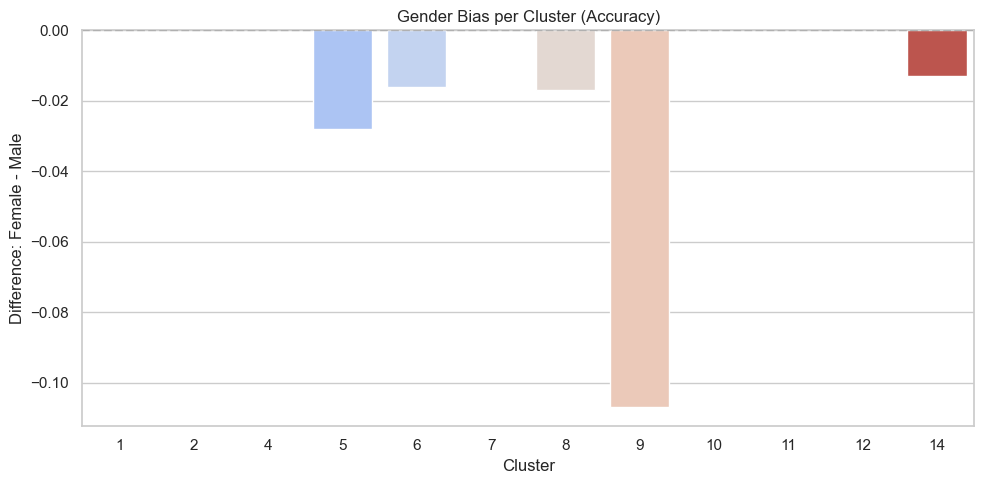

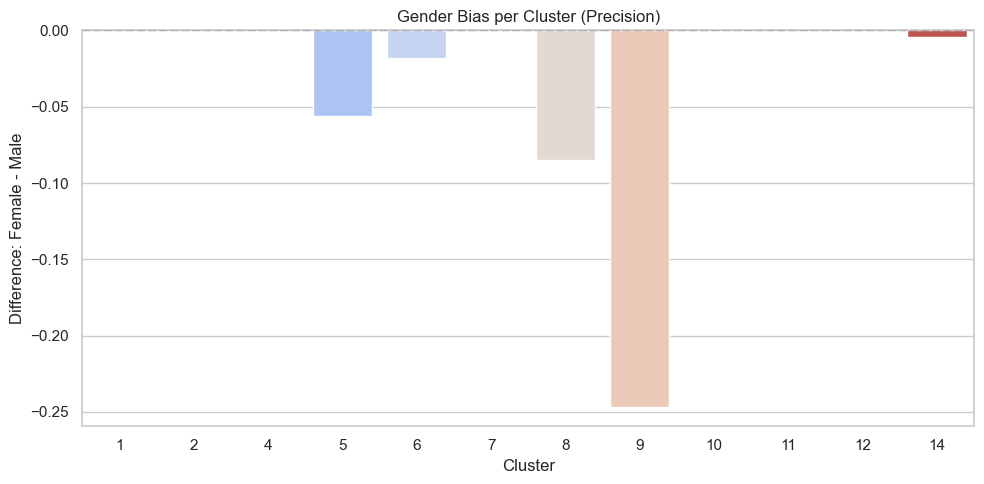

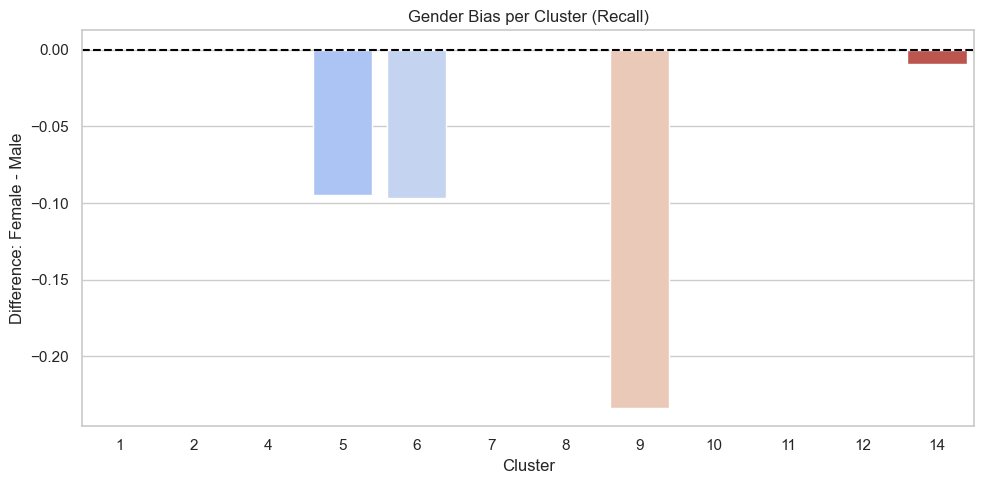

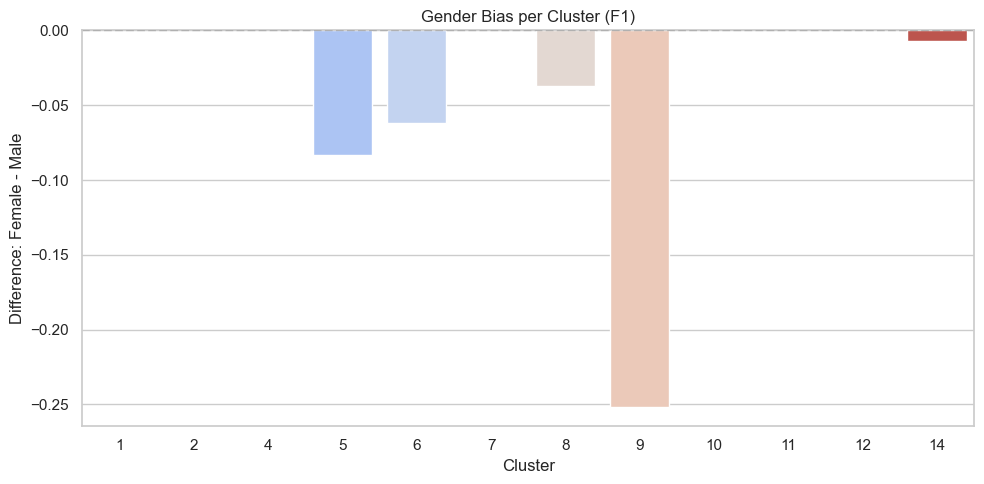

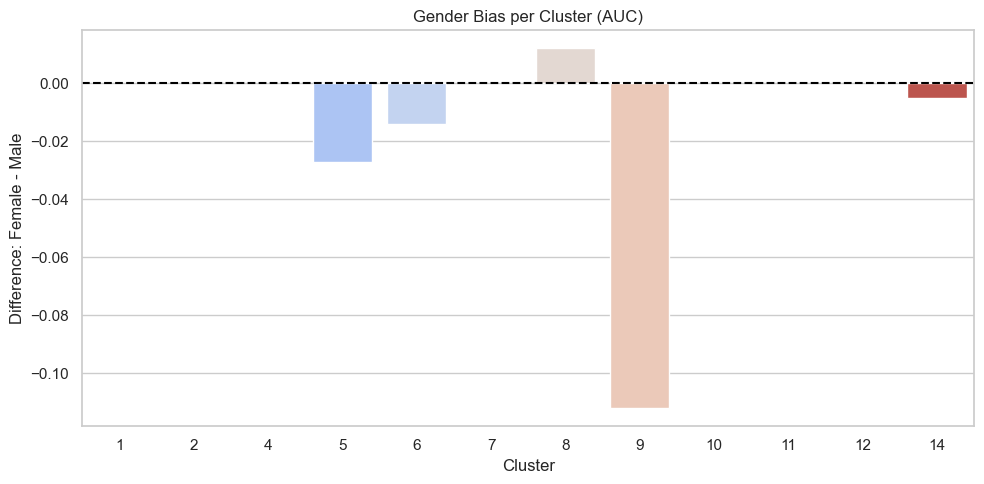

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a consistent style
sns.set(style="whitegrid")

# Metrics to plot
bias_metrics = ['Bias_Accuracy', 'Bias_Precision', 'Bias_Recall', 'Bias_F1', 'Bias_AUC']

# Plot each bias metric
for metric in bias_metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Cluster', y=metric, data=pivoted, palette='coolwarm')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Gender Bias per Cluster ({metric.replace("Bias_", "")})')
    plt.ylabel(f'Difference: Female - Male')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
